In [31]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/train.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish


In [34]:
IMAGE_SIZE = 256
BATCH_SIZE = 15
CHANNELS=3
EPOCHS = 200

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/train', 
  shuffle = True ,
  image_size = (IMAGE_SIZE,IMAGE_SIZE),
  batch_size= BATCH_SIZE
)

Found 541 files belonging to 11 classes.


In [36]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes)
print(class_names)

11
['Armenia', 'Australia', 'Germany', 'Hungary+Slovakia+Croatia', 'Indonesia-Bali', 'Japan', 'Malaysia+Indonesia', 'Portugal+Brazil', 'Russia', 'Spain', 'Thailand']


In [37]:
len(dataset)

37

In [38]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(15, 256, 256, 3)
[10  4  0  1 10  9  2  2  2  5 10  7  9  3  6]


In [39]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch[0])

tf.Tensor(
[[[240.       241.       246.      ]
  [240.       241.       246.      ]
  [239.14844  241.89844  246.77344 ]
  ...
  [235.875    245.875    255.      ]
  [235.       245.       254.125   ]
  [235.61719  244.61719  253.61719 ]]

 [[240.35156  241.35156  246.35156 ]
  [238.625    242.       246.25    ]
  [239.       242.375    246.625   ]
  ...
  [236.92969  245.92969  254.92969 ]
  [236.       246.       255.      ]
  [235.625    244.375    255.      ]]

 [[238.72656  242.72656  245.72656 ]
  [238.3125   241.9375   245.6875  ]
  [239.375    242.375    247.375   ]
  ...
  [235.49219  244.74219  255.      ]
  [235.3125   245.3125   254.3125  ]
  [236.       245.       254.      ]]

 ...

 [[ 95.14844   92.39844   94.64844 ]
  [ 91.88281   91.38281   91.63281 ]
  [ 92.07031   92.82031   92.44531 ]
  ...
  [ 32.242188  34.242188  33.242188]
  [ 33.125     37.        33.375   ]
  [ 33.710938  34.960938  34.335938]]

 [[ 88.1875    88.1875    90.1875  ]
  [ 87.25      87.25      

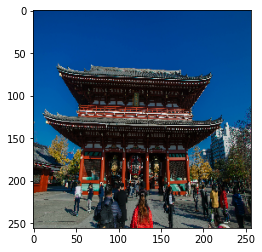

In [40]:
for image_batch , label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8')) # type flot to uint8

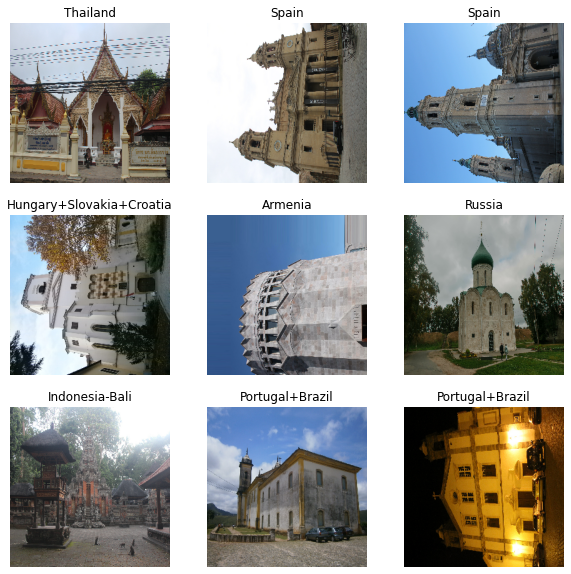

In [41]:
plt.figure(figsize=(10 , 10))
for image_batch , label_batch in dataset.take(1):
  for i in range(9):
    ax =  plt.subplot(3 , 3 ,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [42]:
def get_dataset_partitions_tf(ds , train_split = 0.8 , val_split = 0.1, test_split = 0.1 , shuffle = True , shuffle_size = 10000):
  ds_size =  len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 12)

  train_size =int(train_split * ds_size )
  val_size = int(val_split * ds_size)
  
  train_ds =ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds , val_ds , test_ds

In [43]:
train_ds , val_ds , test_ds =  get_dataset_partitions_tf(dataset)

In [44]:
len(train_ds)

29

In [45]:
len(val_ds)

3

In [46]:
len(test_ds)

5

In [47]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [48]:
resize_and_rescale = tf.keras.Sequential([ layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                                                     layers.experimental.preprocessing.Rescaling(1./255),
                                                                    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                                    layers.experimental.preprocessing.RandomRotation(0.2),
                                                                    layers.experimental.preprocessing.RandomZoom(0.1)
                                                                    ])

In [49]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [50]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (15, 256, 256, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (15, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (15, 127, 127, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (15, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (15, 62, 62, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (15, 60, 60, 256)         147712    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (15, 30, 30, 256)        

In [52]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [53]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1,epochs=EPOCHS)

Epoch 1/200
29/29 [==============================] - 46s 814ms/step - loss: 2.3996 - accuracy: 0.0713 - val_loss: 2.3768 - val_accuracy: 0.0444
Epoch 2/200
29/29 [==============================] - 2s 81ms/step - loss: 2.3620 - accuracy: 0.1069 - val_loss: 2.2865 - val_accuracy: 0.0444
Epoch 3/200
29/29 [==============================] - 2s 77ms/step - loss: 2.2914 - accuracy: 0.1283 - val_loss: 2.1144 - val_accuracy: 0.2444
Epoch 4/200
29/29 [==============================] - 2s 78ms/step - loss: 2.2091 - accuracy: 0.1354 - val_loss: 2.2148 - val_accuracy: 0.1556
Epoch 5/200
29/29 [==============================] - 2s 78ms/step - loss: 2.1377 - accuracy: 0.1900 - val_loss: 2.0006 - val_accuracy: 0.1333
Epoch 6/200
29/29 [==============================] - 2s 80ms/step - loss: 2.1137 - accuracy: 0.1900 - val_loss: 2.0156 - val_accuracy: 0.1778
Epoch 7/200
29/29 [==============================] - 2s 82ms/step - loss: 2.0857 - accuracy: 0.2209 - val_loss: 2.0450 - val_accuracy: 0.1778
Epoc

In [54]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
5/5 [==============================] - 20s 34ms/step - loss: 0.6731 - accuracy: 0.8400
Test Accuracy: 84.0%


In [56]:
scores

[0.6730507612228394, 0.8399999737739563]

In [57]:
history

In [58]:
history.params

{'epochs': 200, 'steps': 29, 'verbose': 1}

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
history.history['accuracy']

[0.07125891000032425,
 0.10688836127519608,
 0.12826603651046753,
 0.13539192080497742,
 0.1900237500667572,
 0.1900237500667572,
 0.22090260684490204,
 0.20902612805366516,
 0.20665083825588226,
 0.20190024375915527,
 0.2327791005373001,
 0.24940617382526398,
 0.2375296950340271,
 0.2422802895307541,
 0.22565320134162903,
 0.26128265261650085,
 0.25415676832199097,
 0.24940617382526398,
 0.2802850306034088,
 0.30403801798820496,
 0.30878859758377075,
 0.2874109148979187,
 0.30403801798820496,
 0.3301662802696228,
 0.30166271328926086,
 0.35154393315315247,
 0.294536828994751,
 0.35391923785209656,
 0.2826603353023529,
 0.3206650912761688,
 0.3325415551662445,
 0.31353920698165894,
 0.36342042684555054,
 0.31828978657722473,
 0.3729216158390045,
 0.36342042684555054,
 0.3847981095314026,
 0.36579573154449463,
 0.35866984724998474,
 0.4228028357028961,
 0.3776721954345703,
 0.3444180488586426,
 0.3681710362434387,
 0.35629454255104065,
 0.3847981095314026,
 0.3895486891269684,
 0.408551

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)


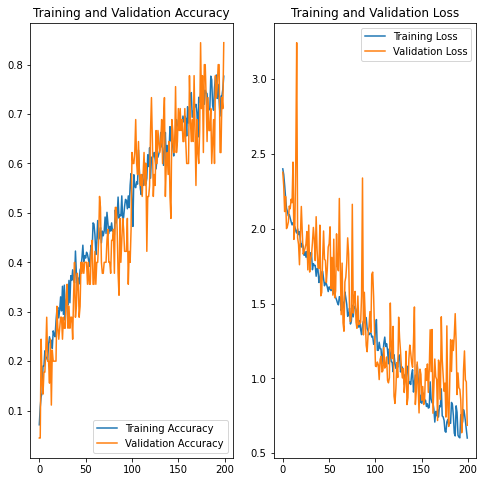

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image  to perdict
actual label :  Australia
perdict image
predicted label :  Australia


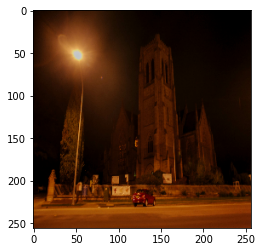

In [71]:
#plt.figure(figsize=(10 , 10))
for image_batch , label_batch in test_ds.take(1):

   first_image = image_batch[0].numpy().astype('uint8')
   first_label = label_batch[0].numpy()

   print('first image  to perdict')
   plt.imshow(first_image)
   print('actual label : ' ,class_names[first_label])
  
   print('perdict image')
   batch_prediction = model.predict(image_batch)
   print('predicted label : ' ,class_names[np.argmax(batch_prediction[0])])


In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

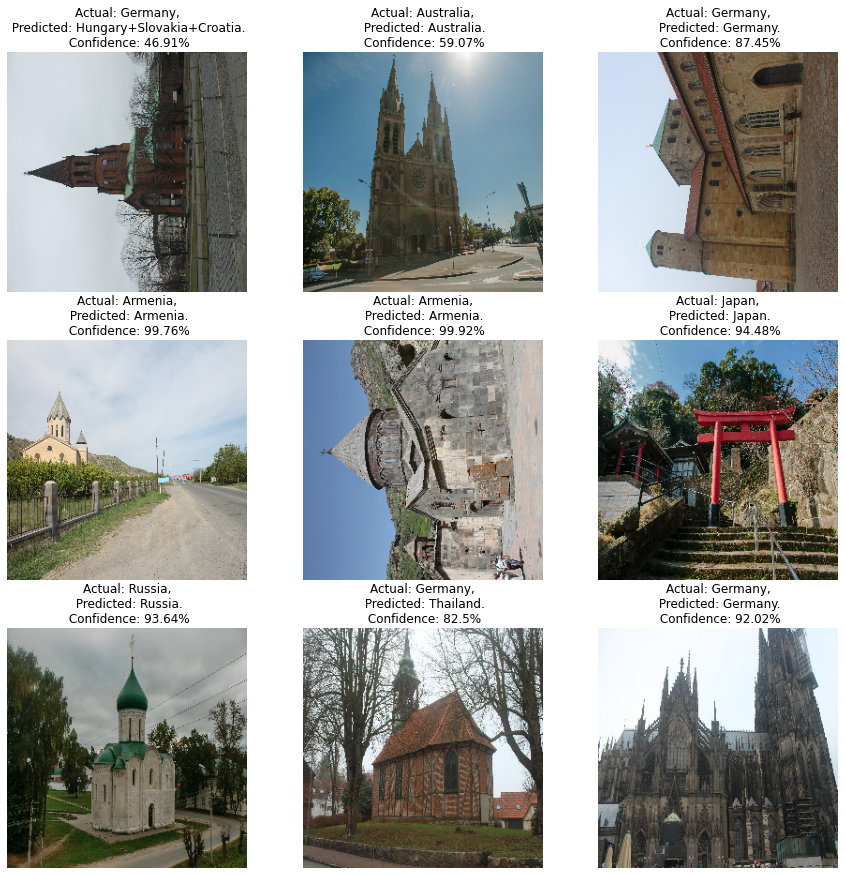

In [74]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

INFO:tensorflow:Assets written to: temple.pkl/assets


In [97]:
# processing for testing

import numpy  as np
from keras.preprocessing  import image

test_image = image.load_img('/content/Berlin_136.JPG' , target_size = (256 , 256, 3))
print(test_image)
predict(model, test_image )

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F20384ED310>


('Thailand', 65.7)

In [114]:
img = tf.io.read_file('/content/st-basil-blazhenny-s-temple-moscow-russia-famous-touristic-place-historical-landmark-red-square-russian-symbol-80137605.jpg')
img = tf.io.decode_jpeg(img , channels= 3)
img = tf.image.resize(img, [256 , 256])
predict(model1, img )

('Thailand', 99.47)

In [111]:
#from keras.models import load_model
#model.save('my_model.h5') 

In [106]:
model1 = load_model('my_model.h5')
